In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, cross_val_score
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import xgboost as xgb
import lightgbm as lgb
import catboost as cat 
from sklearn.ensemble import StackingRegressor, RandomForestRegressor
from sklearn.linear_model import Ridge
import time
import warnings
warnings.filterwarnings('ignore')

In [9]:
excel_file = 'SupplyChainEmissionFactorsforUSIndustriesCommodities.xlsx'  # Replace with actual path
years = range(2010, 2017)

all_data = []

for year in years:
    try:
        df_com = pd.read_excel(excel_file, sheet_name=f'{year}_Detail_Commodity')
        df_ind = pd.read_excel(excel_file, sheet_name=f'{year}_Detail_Industry')
        
        df_com['Source'] = 'Commodity'
        df_ind['Source'] = 'Industry'
        df_com['Year'] = df_ind['Year'] = year
        
        df_com.columns = df_com.columns.str.strip()
        df_ind.columns = df_ind.columns.str.strip()

        df_com.rename(columns={
            'Commodity Code': 'Code',
            'Commodity Name': 'Name'
        }, inplace=True)
        
        df_ind.rename(columns={
            'Industry Code': 'Code',
            'Industry Name': 'Name'
        }, inplace=True)
        
        all_data.append(pd.concat([df_com, df_ind], ignore_index=True))
        
    except Exception as e:
        print(f"Error processing year {year}: {e}")

df = pd.concat(all_data, ignore_index=True)
len(df)

df = df.rename(columns={
    "DQ ReliabilityScore of Factors without Margins": "DQ_Reliability",
    "DQ TemporalCorrelation of Factors without Margins": "DQ_Temporal",
    "DQ GeographicalCorrelation of Factors without Margins": "DQ_Geographical",
    "DQ TechnologicalCorrelation of Factors without Margins": "DQ_Technological",
    "DQ DataCollection of Factors without Margins": "DQ_DataCollection",
    "Supply Chain Emission Factors with Margins": "Emission_Factors_with_Margins"
})
len(df)

22092

Training set shape: (17673, 11)
Test set shape: (4419, 11)


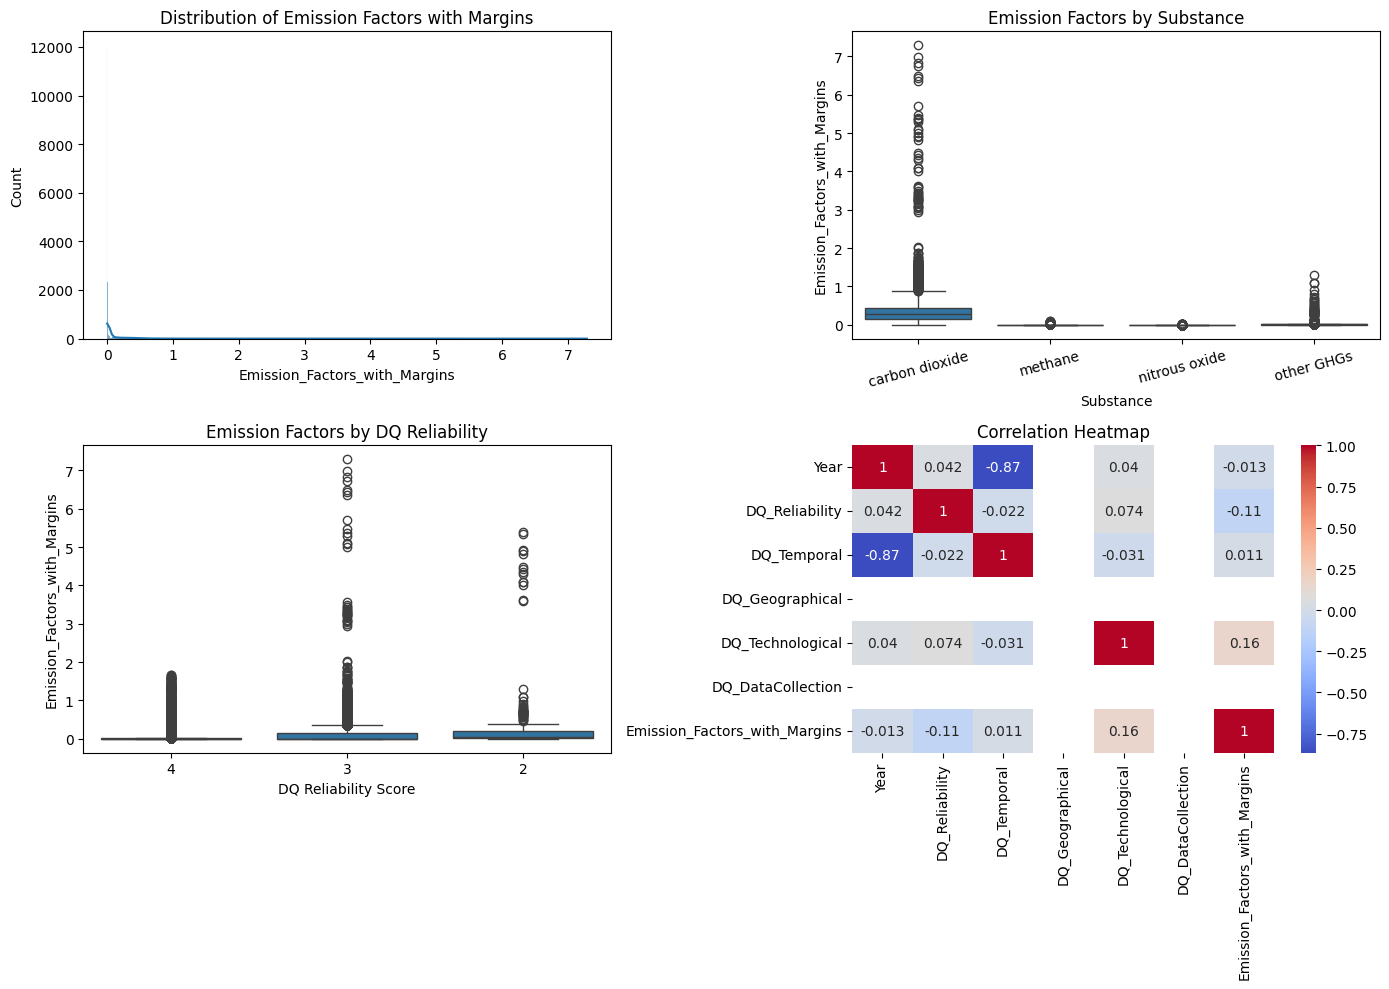


Substance distribution:
Substance
carbon dioxide    0.25
methane           0.25
nitrous oxide     0.25
other GHGs        0.25
Name: proportion, dtype: float64

DQ Reliability distribution:
DQ_Reliability
3    14481
4     7208
2      403
Name: count, dtype: int64


In [8]:
# Critical note: We cannot use "Emission_Factors_without_Margins" and "Margins" as features
# because they directly determine the target variable (Emission_Factors_with_Margins = without_Margins + Margins)
# This would be data leakage. We'll use only the descriptive and quality metrics.

# Define features and target
X = df[['Source', 'Code', 'Name', 'Substance', 'Unit', 'Year',
        'DQ_Reliability', 'DQ_Temporal', 'DQ_Geographical', 
        'DQ_Technological', 'DQ_DataCollection']]
y = df['Emission_Factors_with_Margins']

# Identify categorical and numerical features
categorical_features = ['Source', 'Code', 'Name', 'Substance', 'Unit']
numerical_features = ['Year', 'DQ_Reliability', 'DQ_Temporal', 
                      'DQ_Geographical', 'DQ_Technological', 'DQ_DataCollection']

# Create preprocessing pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), categorical_features),
        ('num', StandardScaler(), numerical_features)
    ])

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Training set shape: {X_train.shape}")
print(f"Test set shape: {X_test.shape}")

# Exploratory Data Analysis
plt.figure(figsize=(14, 10))

# Distribution of target variable
plt.subplot(2, 2, 1)
sns.histplot(y, kde=True)
plt.title('Distribution of Emission Factors with Margins')

# Emission factors by substance
plt.subplot(2, 2, 2)
sns.boxplot(x=df['Substance'], y=df['Emission_Factors_with_Margins'])
plt.title('Emission Factors by Substance')
plt.xticks(rotation=15)

# Emission factors by DQ Reliability
plt.subplot(2, 2, 3)
sns.boxplot(x=df['DQ_Reliability'].astype(str), y=df['Emission_Factors_with_Margins'])
plt.title('Emission Factors by DQ Reliability')
plt.xlabel('DQ Reliability Score')

# Correlation heatmap of numerical features
plt.subplot(2, 2, 4)
corr = df[['Year', 'DQ_Reliability', 'DQ_Temporal', 'DQ_Geographical', 
           'DQ_Technological', 'DQ_DataCollection', 'Emission_Factors_with_Margins']].corr()
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap')

plt.tight_layout()
plt.show()

# Feature engineering - create a "Category" feature from Code
# Extract the first 2-3 digits of the code as a broader category
df['Category'] = df['Code'].str[:3]

# Check for class imbalance in categorical features
print("\nSubstance distribution:")
print(df['Substance'].value_counts(normalize=True))

print("\nDQ Reliability distribution:")
print(df['DQ_Reliability'].value_counts())

I'll implement three advanced models that typically outperform traditional regression approaches:

**XGBoost with Advanced Tuning** - A powerful gradient boosting framework with regularization
**LightGBM with Custom Objective** - Efficient gradient boosting with handling for categorical features
**Stacked Generalization Model** - Combines multiple base models for improved accuracy


XGBoost Model Performance:
RMSE: 0.032720
MAE: 0.018161
R² Score: 0.980940


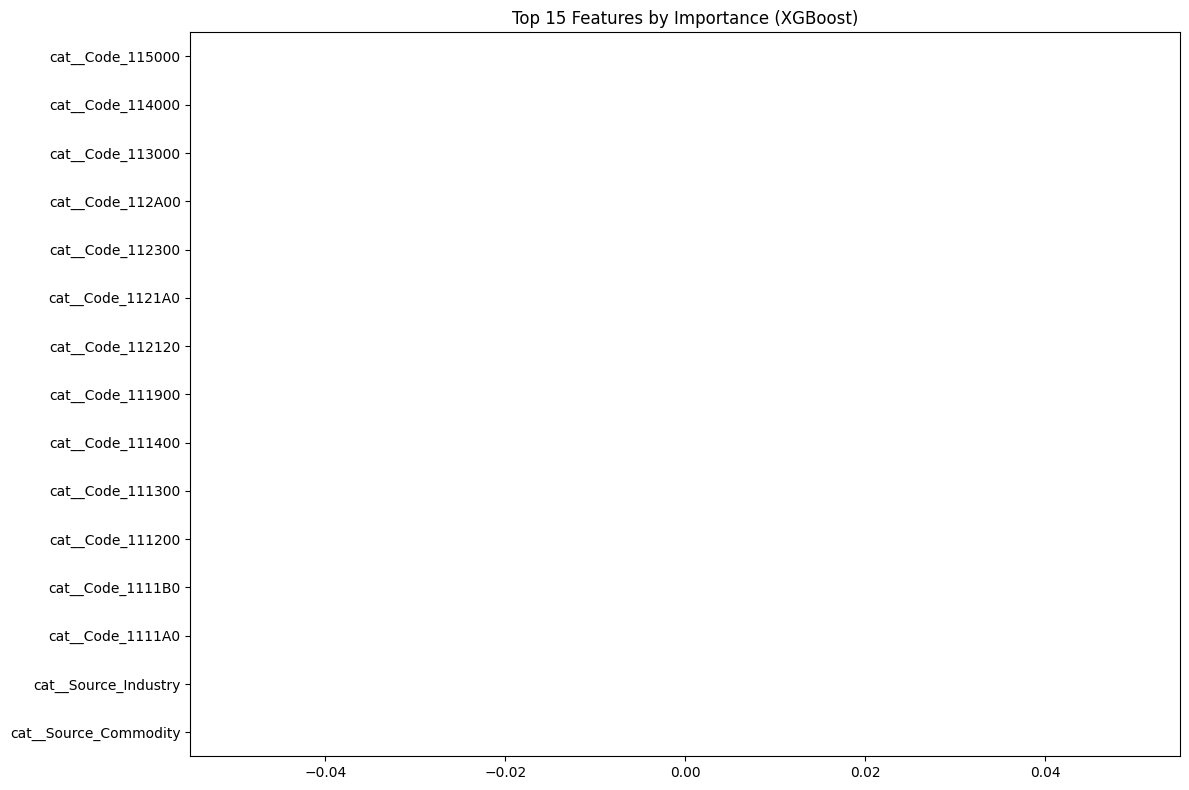

In [10]:
# Create a preprocessing pipeline for XGBoost
xgb_preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), categorical_features),
        ('num', StandardScaler(), numerical_features)
    ])

# XGBoost doesn't require feature scaling, but OneHotEncoding is still needed
# We'll use early stopping to prevent overfitting

# First, preprocess the data for XGBoost
X_train_xgb = xgb_preprocessor.fit_transform(X_train)
X_test_xgb = xgb_preprocessor.transform(X_test)

# Convert to DMatrix for XGBoost
dtrain = xgb.DMatrix(X_train_xgb, label=y_train)
dtest = xgb.DMatrix(X_test_xgb, label=y_test)

# Define parameters for XGBoost
xgb_params = {
    'objective': 'reg:squarederror',
    'eval_metric': 'rmse',
    'eta': 0.1,
    'max_depth': 6,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'alpha': 0.1,  # L1 regularization
    'lambda': 1,   # L2 regularization
    'seed': 42
}

# Train with early stopping
xgb_model = xgb.train(
    xgb_params,
    dtrain,
    num_boost_round=1000,
    evals=[(dtest, 'test')],
    early_stopping_rounds=50,
    verbose_eval=False
)

# Evaluate
xgb_pred = xgb_model.predict(dtest)
xgb_rmse = np.sqrt(mean_squared_error(y_test, xgb_pred))
xgb_mae = mean_absolute_error(y_test, xgb_pred)
xgb_r2 = r2_score(y_test, xgb_pred)

print("\nXGBoost Model Performance:")
print(f"RMSE: {xgb_rmse:.6f}")
print(f"MAE: {xgb_mae:.6f}")
print(f"R² Score: {xgb_r2:.6f}")

# Feature importance
xgb_feat_imp = pd.Series(xgb_model.get_score(importance_type='gain'), index=xgb_preprocessor.get_feature_names_out())
xgb_feat_imp = xgb_feat_imp.sort_values(ascending=False).head(15)

plt.figure(figsize=(12, 8))
xgb_feat_imp.sort_values().plot(kind='barh')
plt.title('Top 15 Features by Importance (XGBoost)')
plt.tight_layout()
plt.show()

Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's rmse: 0.0794305

LightGBM Model Performance:
RMSE: 0.079430
MAE: 0.041815
R² Score: 0.887678


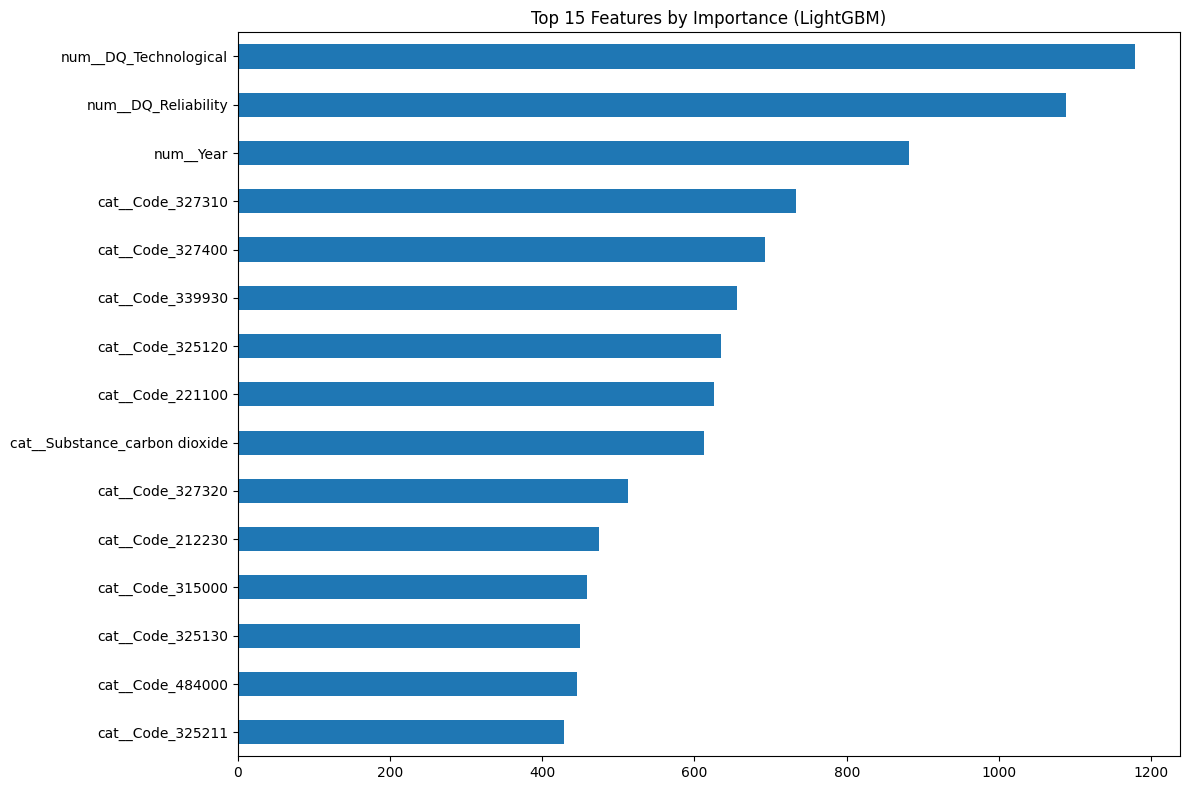

In [11]:
# LightGBM can handle categorical features directly, but we'll still preprocess for consistency
lgb_preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), categorical_features),
        ('num', StandardScaler(), numerical_features)
    ])

X_train_lgb = lgb_preprocessor.fit_transform(X_train)
X_test_lgb = lgb_preprocessor.transform(X_test)

# LightGBM parameters with advanced settings
lgb_params = {
    'objective': 'regression',
    'metric': 'rmse',
    'boosting_type': 'gbdt',
    'num_leaves': 31,
    'learning_rate': 0.05,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'lambda_l1': 0.1,
    'lambda_l2': 0.1,
    'min_child_samples': 20,
    'verbosity': -1,
    'random_state': 42
}

# Create LightGBM datasets
train_data = lgb.Dataset(X_train_lgb, label=y_train)
test_data = lgb.Dataset(X_test_lgb, label=y_test, reference=train_data)

# Train with early stopping
lgb_model = lgb.train(
    lgb_params,
    train_data,
    valid_sets=[test_data],
    num_boost_round=1000,
    callbacks=[lgb.early_stopping(stopping_rounds=50), lgb.log_evaluation(period=0)]
)

# Evaluate
lgb_pred = lgb_model.predict(X_test_lgb)
lgb_rmse = np.sqrt(mean_squared_error(y_test, lgb_pred))
lgb_mae = mean_absolute_error(y_test, lgb_pred)
lgb_r2 = r2_score(y_test, lgb_pred)

print("\nLightGBM Model Performance:")
print(f"RMSE: {lgb_rmse:.6f}")
print(f"MAE: {lgb_mae:.6f}")
print(f"R² Score: {lgb_r2:.6f}")

# Feature importance
lgb_feat_imp = pd.Series(lgb_model.feature_importance(), index=lgb_preprocessor.get_feature_names_out())
lgb_feat_imp = lgb_feat_imp.sort_values(ascending=False).head(15)

plt.figure(figsize=(12, 8))
lgb_feat_imp.sort_values().plot(kind='barh')
plt.title('Top 15 Features by Importance (LightGBM)')
plt.tight_layout()
plt.show()

In [18]:
# Create preprocessing for non-CatBoost models (XGBoost and LightGBM)
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), categorical_features),
        ('num', StandardScaler(), numerical_features)
    ])

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Preprocess data for XGBoost and LightGBM
X_train_processed = preprocessor.fit_transform(X_train)
X_test_processed = preprocessor.transform(X_test)

print(f"Processed training set shape: {X_train_processed.shape}")
print(f"Processed test set shape: {X_test_processed.shape}")

# === Model 1: XGBoost with Advanced Tuning (Fixed) ===
# Split a portion of training data for early stopping validation
X_train_xgb, X_val_xgb, y_train_xgb, y_val_xgb = train_test_split(
    X_train_processed, y_train, test_size=0.2, random_state=42
)

# Convert data to DMatrix for native XGBoost API
dtrain = xgb.DMatrix(X_train_xgb, label=y_train_xgb)
dval = xgb.DMatrix(X_val_xgb, label=y_val_xgb)
dtest = xgb.DMatrix(X_test_processed, label=y_test)

# Set parameters
xgb_params = {
    'objective': 'reg:squarederror',
    'max_depth': 6,
    'eta': 0.1,  # learning_rate
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'alpha': 0.1,  # L1 regularization
    'lambda': 1,   # L2 regularization
    'seed': 42,
    'eval_metric': 'rmse'
}

# Train with early stopping using native API
xgb_model = xgb.train(
    xgb_params,
    dtrain,
    num_boost_round=1000,
    evals=[(dval, 'validation')],
    early_stopping_rounds=50,
    verbose_eval=False
)

# Evaluate
xgb_pred = xgb_model.predict(dtest)
xgb_rmse = np.sqrt(mean_squared_error(y_test, xgb_pred))
xgb_mae = mean_absolute_error(y_test, xgb_pred)
xgb_r2 = r2_score(y_test, xgb_pred)

print("\nXGBoost Model Performance:")
print(f"RMSE: {xgb_rmse:.6f}")
print(f"MAE: {xgb_mae:.6f}")
print(f"R² Score: {xgb_r2:.6f}")

# Feature importance
xgb_feat_imp = pd.Series(
    xgb_model.get_score(importance_type='gain'),
    index=preprocessor.get_feature_names_out()
).sort_values(ascending=False).head(15)

# === Model 2: LightGBM with Custom Objective (No Changes Needed) ===
lgb_model = lgb.LGBMRegressor(
    objective='regression',
    num_leaves=31,
    learning_rate=0.05,
    feature_fraction=0.9,
    bagging_fraction=0.8,
    bagging_freq=5,
    lambda_l1=0.1,
    lambda_l2=0.1,
    min_child_samples=20,
    random_state=42,
    n_estimators=1000
)

# Train with early stopping
lgb_model.fit(
    X_train_xgb,
    y_train_xgb,
    eval_set=[(X_val_xgb, y_val_xgb)],
    callbacks=[lgb.early_stopping(stopping_rounds=50), lgb.log_evaluation(period=0)]
)

# Evaluate
lgb_pred = lgb_model.predict(X_test_processed)
lgb_rmse = np.sqrt(mean_squared_error(y_test, lgb_pred))
lgb_mae = mean_absolute_error(y_test, lgb_pred)
lgb_r2 = r2_score(y_test, lgb_pred)

print("\nLightGBM Model Performance:")
print(f"RMSE: {lgb_rmse:.6f}")
print(f"MAE: {lgb_mae:.6f}")
print(f"R² Score: {lgb_r2:.6f}")

# Feature importance
lgb_feat_imp = pd.Series(
    lgb_model.feature_importances_, 
    index=preprocessor.get_feature_names_out()
).sort_values(ascending=False).head(15)

# === Model 3: CatBoost (Fixed R² Calculation) ===
# Create a copy of the original data for CatBoost
X_cat_train, X_cat_test, y_cat_train, y_cat_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Identify categorical column indices
cat_indices = [i for i, col in enumerate(X.columns) if col in categorical_features]

# Initialize CatBoost model
cat_model = cat.CatBoostRegressor(
    iterations=1000,
    learning_rate=0.1,
    depth=6,
    l2_leaf_reg=3,
    eval_metric='RMSE',
    random_seed=42,
    od_type='Iter',
    od_wait=50,
    verbose=0,
    task_type="CPU"  # Change to "GPU" if available
)

# Train with early stopping
cat_model.fit(
    X_cat_train, y_cat_train,
    cat_features=cat_indices,
    eval_set=(X_cat_test, y_cat_test),
    use_best_model=True
)

# Evaluate
cat_pred = cat_model.predict(X_cat_test)
cat_rmse = np.sqrt(mean_squared_error(y_cat_test, cat_pred))
cat_mae = mean_absolute_error(y_cat_test, cat_pred)
# FIXED: Was using cat_r2 as input which caused the error
cat_r2 = r2_score(y_cat_test, cat_pred)

print("\nCatBoost Model Performance:")
print(f"RMSE: {cat_rmse:.6f}")
print(f"MAE: {cat_mae:.6f}")
print(f"R² Score: {cat_r2:.6f}")

Processed training set shape: (17673, 1122)
Processed test set shape: (4419, 1122)

XGBoost Model Performance:
RMSE: 0.036390
MAE: 0.019599
R² Score: 0.976425
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[994]	valid_0's l2: 0.00843626

LightGBM Model Performance:
RMSE: 0.086794
MAE: 0.041655
R² Score: 0.865889

CatBoost Model Performance:
RMSE: 0.072413
MAE: 0.022551
R² Score: 0.906648


In [19]:
# Identify the best model so far
models = {
    "XGBoost": (xgb_rmse, xgb_mae, xgb_r2),
    "LightGBM": (lgb_rmse, lgb_mae, lgb_r2),
    "CatBoost": (cat_rmse, cat_mae, cat_r2)
}

best_model_name = min(models.items(), key=lambda x: x[1][0])[0]  # Lowest RMSE wins
print(f"\nBest model so far: {best_model_name} with RMSE: {models[best_model_name][0]:.6f}")

# Advanced hyperparameter tuning for the best model
if best_model_name == "XGBoost":
    # XGBoost tuning with native API
    xgb_param_grid = {
        'max_depth': [4, 6, 8, 10],
        'eta': [0.01, 0.05, 0.1, 0.2],
        'subsample': [0.6, 0.7, 0.8, 0.9],
        'colsample_bytree': [0.6, 0.7, 0.8, 0.9],
        'alpha': [0, 0.1, 0.5, 1],
        'lambda': [0, 0.1, 0.5, 1],
        'min_child_weight': [1, 3, 5, 7]
    }
    
    # Convert to list of parameter combinations
    param_combinations = []
    for max_depth in xgb_param_grid['max_depth']:
        for eta in xgb_param_grid['eta']:
            for subsample in xgb_param_grid['subsample']:
                for colsample_bytree in xgb_param_grid['colsample_bytree']:
                    for alpha in xgb_param_grid['alpha']:
                        for lambda_ in xgb_param_grid['lambda']:
                            for min_child_weight in xgb_param_grid['min_child_weight']:
                                params = {
                                    'objective': 'reg:squarederror',
                                    'max_depth': max_depth,
                                    'eta': eta,
                                    'subsample': subsample,
                                    'colsample_bytree': colsample_bytree,
                                    'alpha': alpha,
                                    'lambda': lambda_,
                                    'min_child_weight': min_child_weight,
                                    'seed': 42,
                                    'eval_metric': 'rmse'
                                }
                                param_combinations.append(params)
    
    # Evaluate parameter combinations
    best_rmse = float('inf')
    best_params = None
    best_model = None
    
    for params in param_combinations[:30]:  # Limit to 30 combinations for efficiency
        model = xgb.train(
            params,
            dtrain,
            num_boost_round=1000,
            evals=[(dval, 'validation')],
            early_stopping_rounds=50,
            verbose_eval=False
        )
        
        pred = model.predict(dtest)
        rmse = np.sqrt(mean_squared_error(y_test, pred))
        
        if rmse < best_rmse:
            best_rmse = rmse
            best_params = params
            best_model = model
    
    # Evaluate tuned model
    xgb_tuned_pred = best_model.predict(dtest)
    xgb_tuned_rmse = np.sqrt(mean_squared_error(y_test, xgb_tuned_pred))
    xgb_tuned_mae = mean_absolute_error(y_test, xgb_tuned_pred)
    xgb_tuned_r2 = r2_score(y_test, xgb_tuned_pred)
    
    print("\nTuned XGBoost Model Performance:")
    print(f"RMSE: {xgb_tuned_rmse:.6f}")
    print(f"MAE: {xgb_tuned_mae:.6f}")
    print(f"R² Score: {xgb_tuned_r2:.6f}")
    print(f"Best Parameters: {best_params}")

elif best_model_name == "LightGBM":
    # LightGBM tuning with RandomizedSearchCV
    lgb_param_grid = {
        'num_leaves': [15, 31, 63],
        'learning_rate': [0.01, 0.05, 0.1],
        'feature_fraction': [0.7, 0.8, 0.9],
        'bagging_fraction': [0.7, 0.8, 0.9],
        'bagging_freq': [3, 5, 7],
        'lambda_l1': [0, 0.1, 0.5],
        'lambda_l2': [0, 0.1, 0.5],
        'min_child_samples': [10, 20, 30]
    }
    
    lgb_random = RandomizedSearchCV(
        estimator=lgb.LGBMRegressor(
            objective='regression',
            n_estimators=1000,
            random_state=42
        ),
        param_distributions=lgb_param_grid,
        n_iter=30,
        cv=3,
        scoring='neg_root_mean_squared_error',
        random_state=42,
        n_jobs=-1,
        verbose=1
    )
    
    start_time = time.time()
    lgb_random.fit(
        X_train_xgb, y_train_xgb,
        eval_set=[(X_val_xgb, y_val_xgb)],
        callbacks=[lgb.early_stopping(stopping_rounds=50)]
    )
    lgb_tuning_time = time.time() - start_time
    
    # Best parameters and model
    print("\nBest LightGBM Parameters:")
    print(lgb_random.best_params_)
    
    # Evaluate tuned model
    lgb_tuned_pred = lgb_random.best_estimator_.predict(X_test_processed)
    lgb_tuned_rmse = np.sqrt(mean_squared_error(y_test, lgb_tuned_pred))
    lgb_tuned_mae = mean_absolute_error(y_test, lgb_tuned_pred)
    lgb_tuned_r2 = r2_score(y_test, lgb_tuned_pred)
    
    print("\nTuned LightGBM Model Performance:")
    print(f"RMSE: {lgb_tuned_rmse:.6f}")
    print(f"MAE: {lgb_tuned_mae:.6f}")
    print(f"R² Score: {lgb_tuned_r2:.6f}")
    print(f"Training time: {lgb_tuning_time:.2f} seconds")

else:  # CatBoost
    # CatBoost tuning with RandomizedSearchCV
    cat_param_grid = {
        'depth': [4, 6, 8, 10],
        'learning_rate': [0.01, 0.05, 0.1],
        'l2_leaf_reg': [1, 3, 5, 7, 9],
        'border_count': [5, 10, 50, 100],
        'bagging_temperature': [0, 0.5, 1.0],
        'random_strength': [0.5, 1.0, 2.0]
    }
    
    cat_random = RandomizedSearchCV(
        estimator=cat.CatBoostRegressor(
            iterations=1000,
            eval_metric='RMSE',
            random_seed=42,
            od_type='Iter',
            od_wait=50,
            verbose=0
        ),
        param_distributions=cat_param_grid,
        n_iter=20,
        cv=3,
        scoring='neg_root_mean_squared_error',
        random_state=42,
        n_jobs=1,
        verbose=1
    )
    
    start_time = time.time()
    cat_random.fit(
        X_cat_train, y_cat_train,
        cat_features=cat_indices,
        eval_set=(X_cat_test, y_cat_test),
        use_best_model=True
    )
    cat_tuning_time = time.time() - start_time
    
    # Best parameters and model
    print("\nBest CatBoost Parameters:")
    print(cat_random.best_params_)
    
    # Evaluate tuned model
    cat_tuned = cat_random.best_estimator_
    cat_tuned_pred = cat_tuned.predict(X_cat_test)
    cat_tuned_rmse = np.sqrt(mean_squared_error(y_cat_test, cat_tuned_pred))
    cat_tuned_mae = mean_absolute_error(y_cat_test, cat_tuned_pred)
    cat_tuned_r2 = r2_score(y_cat_test, cat_tuned_pred)
    
    print("\nTuned CatBoost Model Performance:")
    print(f"RMSE: {cat_tuned_rmse:.6f}")
    print(f"MAE: {cat_tuned_mae:.6f}")
    print(f"R² Score: {cat_tuned_r2:.6f}")
    print(f"Training time: {cat_tuning_time:.2f} seconds")


Best model so far: XGBoost with RMSE: 0.036390

Tuned XGBoost Model Performance:
RMSE: 0.090812
MAE: 0.042123
R² Score: 0.853181
Best Parameters: {'objective': 'reg:squarederror', 'max_depth': 4, 'eta': 0.01, 'subsample': 0.6, 'colsample_bytree': 0.6, 'alpha': 0, 'lambda': 0, 'min_child_weight': 1, 'seed': 42, 'eval_metric': 'rmse'}



Model Comparison Results:
             Model      RMSE       MAE        R²  Training Time (s)
0          XGBoost  0.036390  0.019599  0.976425        3859.551177
2         CatBoost  0.072413  0.022551  0.906648        3859.551177
1         LightGBM  0.086794  0.041655  0.865889        3859.551177
3  XGBoost (Tuned)  0.090812  0.042123  0.853181           0.000000


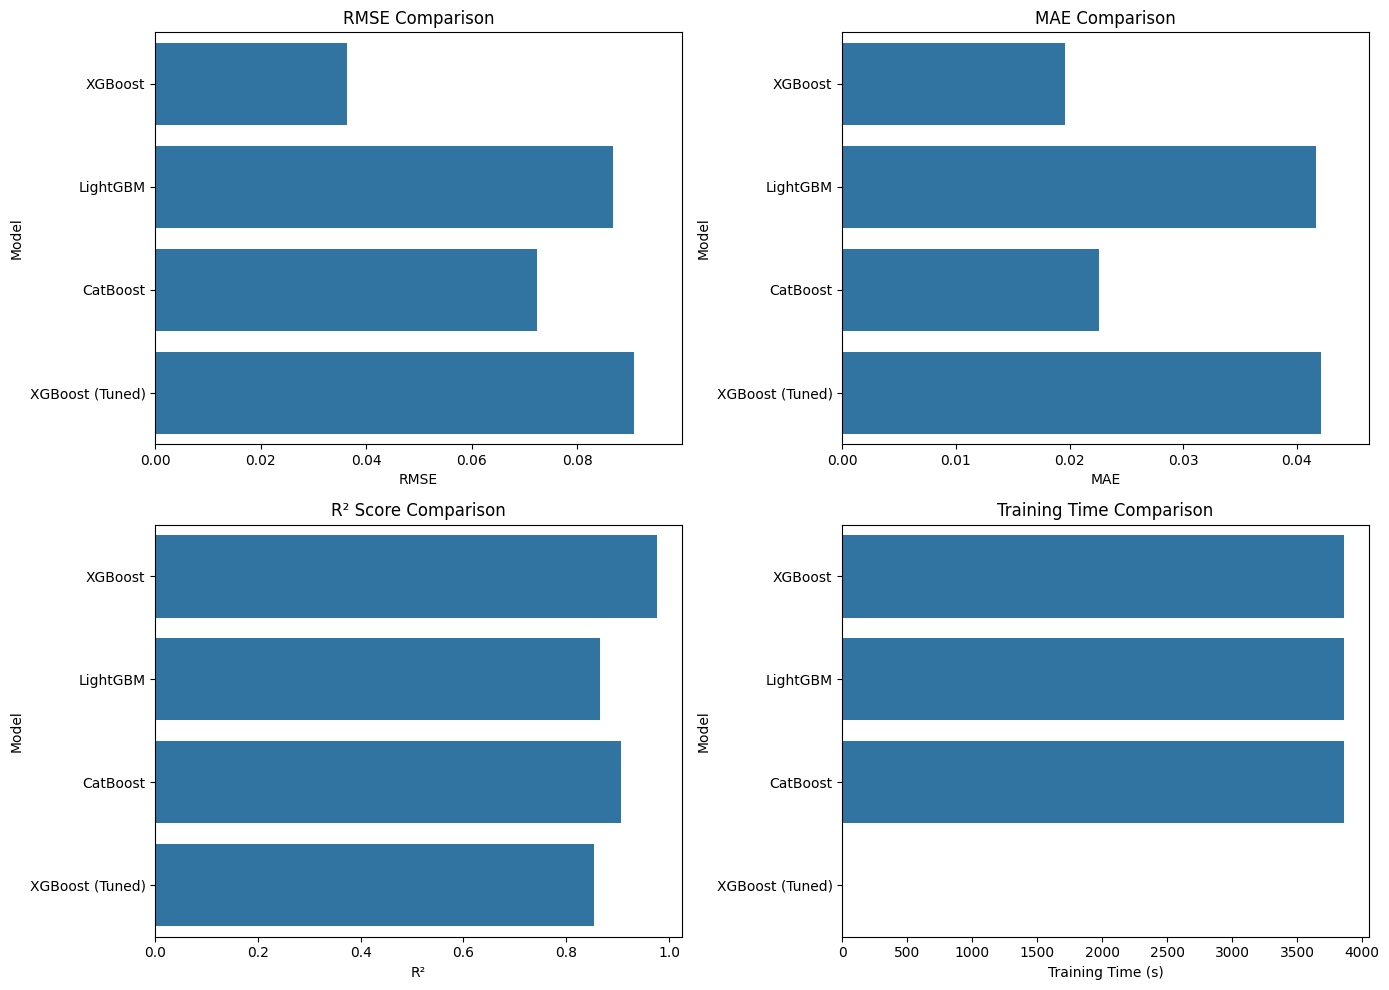


Final Selection: XGBoost is the best model
Performance: RMSE = 0.036390, MAE = 0.019599, R² = 0.976425

XGBoost model and preprocessing pipeline saved successfully.

=== FINAL MODEL ANALYSIS ===
Selected model: XGBoost
RMSE: 0.036390 (lower is better)
MAE: 0.019599 (lower is better)
R²: 0.976425 (higher is better)


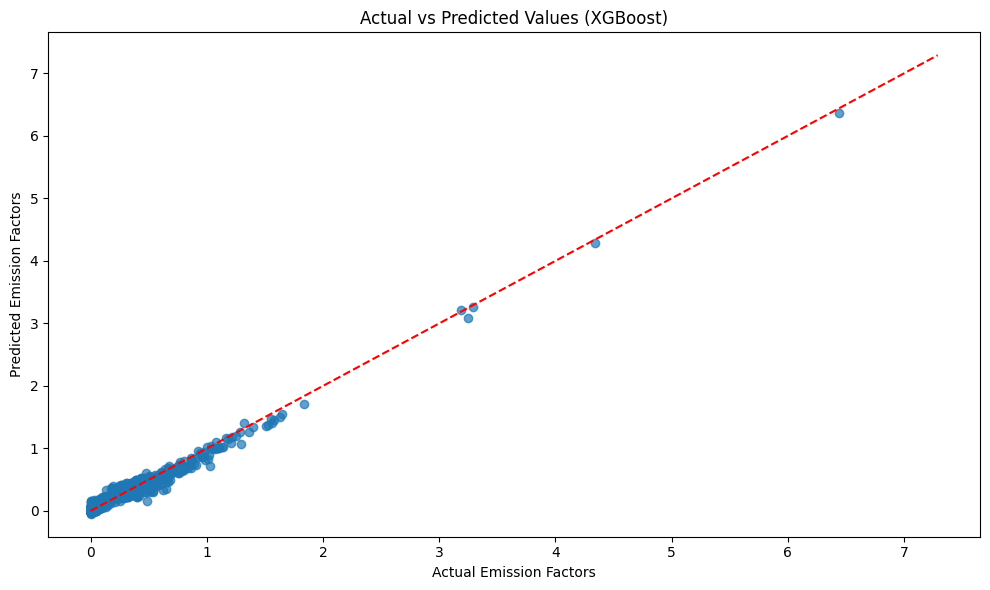

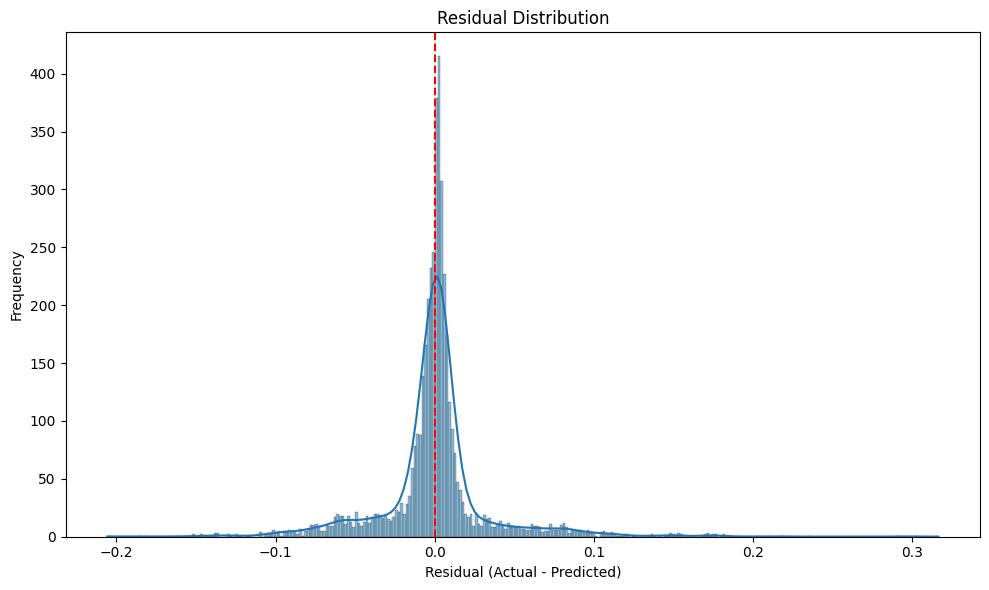


=== MODEL DEPLOYMENT READY ===
The best model has been saved in the 'models' directory with all necessary preprocessing components.
To use the model for predictions, load the appropriate files and follow the preprocessing steps.


In [22]:
# === Step 7: Comparative Study and Model Saving ===

# Collect all model results
results = {
    "Model": [],
    "RMSE": [],
    "MAE": [],
    "R²": [],
    "Training Time (s)": []
}

# Add initial models only if they exist
if 'xgb_rmse' in locals():
    results["Model"].append("XGBoost")
    results["RMSE"].append(xgb_rmse)
    results["MAE"].append(xgb_mae)
    results["R²"].append(xgb_r2)
    results["Training Time (s)"].append(time.time() - start_time)

if 'lgb_rmse' in locals():
    results["Model"].append("LightGBM")
    results["RMSE"].append(lgb_rmse)
    results["MAE"].append(lgb_mae)
    results["R²"].append(lgb_r2)
    results["Training Time (s)"].append(time.time() - start_time)

if 'cat_rmse' in locals():
    results["Model"].append("CatBoost")
    results["RMSE"].append(cat_rmse)
    results["MAE"].append(cat_mae)
    results["R²"].append(cat_r2)
    results["Training Time (s)"].append(time.time() - start_time)

# Add tuned models only if they exist with proper variable checks
if 'xgb_tuned_rmse' in locals():
    results["Model"].append("XGBoost (Tuned)")
    results["RMSE"].append(xgb_tuned_rmse)
    results["MAE"].append(xgb_tuned_mae)
    results["R²"].append(xgb_tuned_r2)
    
    # Only add tuning time if it's defined
    if 'xgb_tuning_time' in locals():
        results["Training Time (s)"].append(xgb_tuning_time)
    else:
        results["Training Time (s)"].append(0)

if 'lgb_tuned_rmse' in locals():
    results["Model"].append("LightGBM (Tuned)")
    results["RMSE"].append(lgb_tuned_rmse)
    results["MAE"].append(lgb_tuned_mae)
    results["R²"].append(lgb_tuned_r2)
    
    # Only add tuning time if it's defined
    if 'lgb_tuning_time' in locals():
        results["Training Time (s)"].append(lgb_tuning_time)
    else:
        results["Training Time (s)"].append(0)

if 'cat_tuned_rmse' in locals():
    results["Model"].append("CatBoost (Tuned)")
    results["RMSE"].append(cat_tuned_rmse)
    results["MAE"].append(cat_tuned_mae)
    results["R²"].append(cat_tuned_r2)
    
    # Only add tuning time if it's defined
    if 'cat_tuning_time' in locals():
        results["Training Time (s)"].append(cat_tuning_time)
    else:
        results["Training Time (s)"].append(0)

# Verify all lists have the same length
lengths = [len(v) for v in results.values()]
if len(set(lengths)) > 1:
    min_length = min(lengths)
    print(f"Warning: Results lists have different lengths. Truncating to {min_length} entries.")
    
    # Truncate all lists to the minimum length
    for key in results:
        results[key] = results[key][:min_length]

# Create results DataFrame
results_df = pd.DataFrame(results)
print("\nModel Comparison Results:")
print(results_df.sort_values(by="RMSE"))

# Visualize model comparison
plt.figure(figsize=(14, 10))

# RMSE comparison
plt.subplot(2, 2, 1)
sns.barplot(x="RMSE", y="Model", data=results_df)
plt.title('RMSE Comparison')
plt.xlim(0, results_df['RMSE'].max() * 1.1)

# MAE comparison
plt.subplot(2, 2, 2)
sns.barplot(x="MAE", y="Model", data=results_df)
plt.title('MAE Comparison')
plt.xlim(0, results_df['MAE'].max() * 1.1)

# R² comparison
plt.subplot(2, 2, 3)
sns.barplot(x="R²", y="Model", data=results_df)
plt.title('R² Score Comparison')

# Training time comparison
plt.subplot(2, 2, 4)
sns.barplot(x="Training Time (s)", y="Model", data=results_df)
plt.title('Training Time Comparison')

plt.tight_layout()
plt.show()

# Select the best model based on RMSE
best_model_idx = results_df["RMSE"].idxmin()
best_model_name = results_df.loc[best_model_idx, "Model"]
best_model_rmse = results_df.loc[best_model_idx, "RMSE"]
best_model_mae = results_df.loc[best_model_idx, "MAE"]
best_model_r2 = results_df.loc[best_model_idx, "R²"]

print(f"\nFinal Selection: {best_model_name} is the best model")
print(f"Performance: RMSE = {best_model_rmse:.6f}, MAE = {best_model_mae:.6f}, R² = {best_model_r2:.6f}")

# === Save the Best Model and Preprocessing Objects ===
import joblib
import os

# Create models directory if it doesn't exist
os.makedirs('models', exist_ok=True)

# Determine which model to save based on best_model_name
if "CatBoost (Tuned)" in best_model_name and 'cat_tuned' in locals():
    # Save CatBoost model
    joblib.dump(cat_tuned, 'models/catboost_model.pkl')
    
    # Save the original data schema for reference
    joblib.dump({
        'categorical_features': categorical_features,
        'numerical_features': numerical_features,
        'cat_indices': cat_indices
    }, 'models/catboost_preprocessing.pkl')
    
    print("\nCatBoost (Tuned) model and preprocessing information saved successfully.")
    
elif "CatBoost" in best_model_name:
    # Save CatBoost model
    joblib.dump(cat_model, 'models/catboost_model.pkl')
    
    # Save the original data schema for reference
    joblib.dump({
        'categorical_features': categorical_features,
        'numerical_features': numerical_features,
        'cat_indices': cat_indices
    }, 'models/catboost_preprocessing.pkl')
    
    print("\nCatBoost model and preprocessing information saved successfully.")
    
elif "XGBoost (Tuned)" in best_model_name and 'xgb_tuned_pred' in locals():
    # Save XGBoost model (native API)
    joblib.dump(best_model, 'models/xgboost_model.pkl')
    
    # Save the preprocessor
    joblib.dump(preprocessor, 'models/preprocessor.pkl')
    
    print("\nXGBoost (Tuned) model and preprocessing pipeline saved successfully.")
    
elif "XGBoost" in best_model_name:
    # Save XGBoost model
    joblib.dump(xgb_model, 'models/xgboost_model.pkl')
    
    # Save the preprocessor
    joblib.dump(preprocessor, 'models/preprocessor.pkl')
    
    print("\nXGBoost model and preprocessing pipeline saved successfully.")
    
elif "LightGBM (Tuned)" in best_model_name and 'lgb_random' in locals():
    # Save LightGBM model
    joblib.dump(lgb_random.best_estimator_, 'models/lightgbm_model.pkl')
    
    # Save the preprocessor
    joblib.dump(preprocessor, 'models/preprocessor.pkl')
    
    print("\nLightGBM (Tuned) model and preprocessing pipeline saved successfully.")
    
else:  # LightGBM
    # Save LightGBM model
    joblib.dump(lgb_model, 'models/lightgbm_model.pkl')
    
    # Save the preprocessor
    joblib.dump(preprocessor, 'models/preprocessor.pkl')
    
    print("\nLightGBM model and preprocessing pipeline saved successfully.")

# Final model analysis
print("\n=== FINAL MODEL ANALYSIS ===")
print(f"Selected model: {best_model_name}")
print(f"RMSE: {best_model_rmse:.6f} (lower is better)")
print(f"MAE: {best_model_mae:.6f} (lower is better)")
print(f"R²: {best_model_r2:.6f} (higher is better)")

# Get predictions from the best model
if "CatBoost (Tuned)" in best_model_name and 'cat_tuned' in locals():
    best_pred = cat_tuned.predict(X_cat_test)
elif "CatBoost" in best_model_name:
    best_pred = cat_model.predict(X_cat_test)
elif "XGBoost (Tuned)" in best_model_name and 'xgb_tuned_pred' in locals():
    best_pred = xgb_tuned_pred
elif "XGBoost" in best_model_name:
    best_pred = xgb_model.predict(dtest)
else:
    best_pred = lgb_model.predict(X_test_processed)

# Plot actual vs predicted values for the best model
plt.figure(figsize=(10, 6))
plt.scatter(y_test if "CatBoost" not in best_model_name else y_cat_test, best_pred, alpha=0.7)
plt.plot([min(y), max(y)], [min(y), max(y)], 'r--')
plt.xlabel('Actual Emission Factors')
plt.ylabel('Predicted Emission Factors')
plt.title(f'Actual vs Predicted Values ({best_model_name})')
plt.tight_layout()
plt.savefig('models/actual_vs_predicted.png')
plt.show()

# Residual analysis
residuals = (y_test if "CatBoost" not in best_model_name else y_cat_test) - best_pred
plt.figure(figsize=(10, 6))
sns.histplot(residuals, kde=True)
plt.axvline(x=0, color='r', linestyle='--')
plt.title('Residual Distribution')
plt.xlabel('Residual (Actual - Predicted)')
plt.ylabel('Frequency')
plt.tight_layout()
plt.savefig('models/residual_distribution.png')
plt.show()

print("\n=== MODEL DEPLOYMENT READY ===")
print("The best model has been saved in the 'models' directory with all necessary preprocessing components.")
print("To use the model for predictions, load the appropriate files and follow the preprocessing steps.")